In [1]:
import bagpy
from typing import *
from os.path import join, exists
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_results_from_folder(folder: str) -> Dict[str, Tuple[List[float], List[float]]]:
    utn_path = join(folder, "UTN")
    maryland_path = join(folder, "MARYLAND")
    if not exists(utn_path) or not exists(maryland_path):
        print(f"Skipping {folder} because of not having both maryland and UTN")
        return None
    utn_bag_file = glob(join(utn_path, "*.bag.active"))[0]
    maryland_bag_file = glob(join(maryland_path, "*.bag.active"))[0]
    reader_utn = bagpy.bagreader(utn_bag_file)
    reader_maryland = bagpy.bagreader(maryland_bag_file)
    
    def get_odom_df(odom: list) -> pd.DataFrame:
        dic = {"timestamp": [], "x":[], "y": []}
        for o in odom:
            dic["timestamp"].append(o.timestamp.to_sec())
            dic["x"].append(o.message.pose.pose.position.x)
            dic["y"].append(o.message.pose.pose.position.y)
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        # compute cumulative distance traveled
        ret = df.copy()
        ret["x_diff"] = df.x - df.x.shift(1)
        ret["y_diff"] = df.y - df.y.shift(1)
        # euclidean distance.
        ret["dist"] = (ret.x_diff ** 2 + ret.y_diff ** 2) ** 0.5
        ret = ret.iloc[1:, :]
        ret["cum_sum"] = ret.dist.cumsum()
        # remove duplicates
        ret = ret[~ret.index.duplicated(keep="first")]
        return ret
        
    def get_explored_df(reader: bagpy.bagreader) -> pd.DataFrame:
        img_data =  reader.reader.read_messages("/map")
        amt_of_non_unknown = []
        timestamps = []
        for d in img_data:
            img = np.asarray(d.message.data)
            amt_of_non_unknown.append(np.count_nonzero(img != -1))
            timestamps.append(d.timestamp.to_sec())
        amt_of_non_unknown = [0.0025 * item for item in amt_of_non_unknown]
        dic = {"timestamp": timestamps, "m_2_explored": amt_of_non_unknown}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df
    
    def get_times_and_explores(reader: bagpy.bagreader) -> Tuple[List[float], List[float]]:
        gts_data =  reader.reader.read_messages("/create1/gts")
        explored_df = get_explored_df(reader)
        odoms = []
        for odom in gts_data:
            odoms.append(odom)
        odom_df = get_odom_df(odoms)
        return (explored_df, odom_df)
    res = {"UTN": get_times_and_explores(reader_utn), "MARYLAND": get_times_and_explores(reader_maryland)}
    return res

[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_7/UTN/2022-10-14-04-04-47.bag.ac already exists. Not creating.
[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_7/MARYLAND/2022-10-14-04-02-03.bag.ac already exists. Not creating.


In [15]:
def plot_result(res: Dict):
    utn_df=  pd.merge_asof(res["UTN"][0], res["UTN"][1], on="timestamp")
    maryland_df=  pd.merge_asof(res["MARYLAND"][0], res["MARYLAND"][1], on="timestamp")
    utn_df = utn_df.dropna()
    maryland_df = maryland_df.dropna()
    
    plt.plot( utn_df["cum_sum"], utn_df["m_2_explored"], label="UTN")
    plt.plot( maryland_df["cum_sum"], maryland_df["m_2_explored"], label="MARYLAND")
    plt.ylabel("Explored area [m2]")
    plt.xlabel("Distance travelled [m]")
    
    plt.legend()
     

In [16]:
worlds_df = pd.read_pickle("/home/ramiro/.gazebo/worlds_df.pkl")

In [7]:
res_3 = get_results_from_folder("/home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_3")

[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_3/UTN/2022-10-14-04-06-33.bag.ac already exists. Not creating.
[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_3/MARYLAND/2022-10-14-04-06-08.bag.ac already exists. Not creating.


In [11]:
res_9 = get_results_from_folder("/home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_9")

[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_9/UTN/2022-10-14-03-40-44.bag.ac already exists. Not creating.
[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_9/MARYLAND/2022-10-14-03-40-48.bag.ac already exists. Not creating.


In [13]:
res_7 = get_results_from_folder("/home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_7")

[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_7/UTN/2022-10-14-04-04-47.bag.ac already exists. Not creating.
[INFO]  Data folder /home/ramiro/Frontier-Exploration-with-a-prior/src/ROS/create_autonomy/outputs/test_7/MARYLAND/2022-10-14-04-02-03.bag.ac already exists. Not creating.


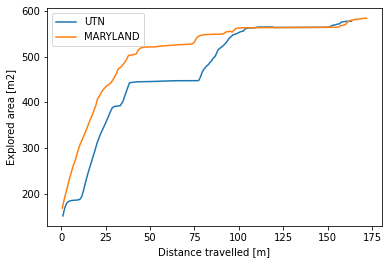

In [12]:
plot_result(res_9)

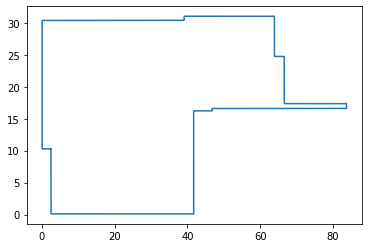

In [25]:
plt.plot(*worlds_df.loc["test_9"].world.free_space_polygon.exterior.xy)

In [24]:
print(f"Area total: {worlds_df.loc['test_9'].free_area}")

Area total: 1593.9369583629668


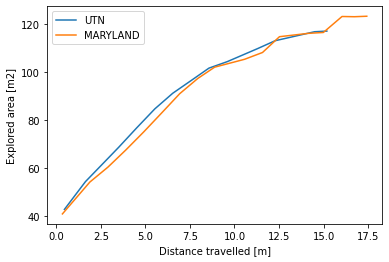

In [14]:
plot_result(res_7)

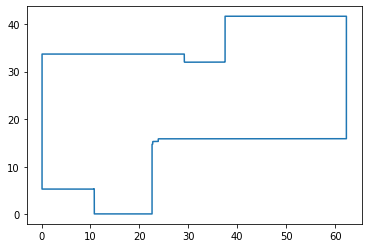

In [33]:
plt.plot(*worlds_df.loc["test_7"].world.free_space_polygon.exterior.xy)

In [27]:
print(f"Area total: {worlds_df.loc['test_7'].free_area}")

Area total: 1588.816181110351


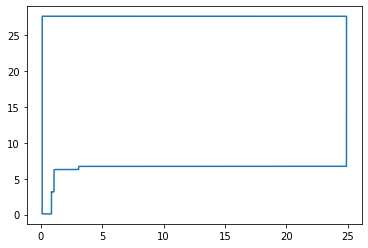

In [31]:
plt.plot(*worlds_df.loc["test_1"].world.free_space_polygon.exterior.xy)